In [1]:
import sys, os, torch
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

if(torch.cuda.device_count() >= 1):
    device = "cuda:1"
else:
    device = 'cpu'

# move directory
os.chdir("..")

import torch
import pandas as pd
from src.config import Config

config = Config()
ts_cols = config.input_features

ts_data = pd.read_csv('./dataset/KSTAR_Disruption_ts_data_extend.csv')
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List_extend.csv', encoding = "euc-kr")

In [2]:
ts_data_origin = pd.read_csv('./dataset/KSTAR_Disruption_ts_data_revised.csv')

In [3]:
ts_shot_origin = ts_data_origin[ts_data_origin.shot == 21310]

In [4]:
ts_shot = ts_data[ts_data.shot == 21310]

In [14]:
# disruption info
t_tq = kstar_shot_list[kstar_shot_list.shot == 21310]['tTQend'].values[0]
t_cq = kstar_shot_list[kstar_shot_list.shot == 21310]['tipminf'].values[0]

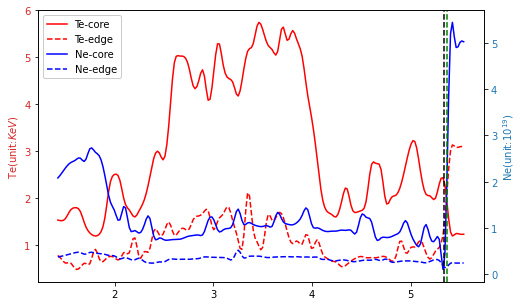

In [52]:
te_core = ts_shot['\\TS_TE_CORE_AVG']
te_edge = ts_shot['\\TS_TE_EDGE_AVG']

ne_core = ts_shot['\\TS_NE_CORE_AVG']
ne_edge = ts_shot['\\TS_NE_EDGE_AVG']

betap = ts_shot['\\BETAP_DLM03']
li = ts_shot['\\li']
q95 = ts_shot['\\q95']
kappa = ts_shot['\\kappa']
ne_ng_ratio = ts_shot['\\ne_nG_ratio']

time_x = ts_shot.time

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1,figsize = (8,5), sharex='row')

ax_te = axes
ln_te_core = ax_te.plot(time_x, te_core, c = 'r', label = 'Te-core')
ln_te_edge = ax_te.plot(time_x, te_edge, c = 'r', linestyle='--', label = 'Te-edge')
ax_te.tick_params(axis='y', labelcolor='tab:red')
ax_te.set_ylabel('Te(unit:$KeV$)', color = 'tab:red')
ax_ne = ax_te.twinx()

ln_ne_core = ax_ne.plot(time_x, ne_core, c = 'b', label = 'Ne-core')
ln_ne_edge = ax_ne.plot(time_x, ne_edge, c = 'b', linestyle='--', label = 'Ne-edge')
ax_ne.tick_params(axis='y', labelcolor='tab:blue')
ax_ne.set_ylabel('Ne(unit:$10^{19}$)', color = 'tab:blue')
ax_ne.axvline(x = t_tq, ymin = 0, ymax = 1, color = "black", linestyle = "dashed", label = 'thermal quench')
ax_ne.axvline(x = t_cq, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = 'current quench')

lns = ln_te_core + ln_te_edge + ln_ne_core + ln_ne_edge
labs = [l.get_label() for l in lns]
ax_ne.legend(lns, labs, loc = 'upper left', facecolor = 'white', framealpha=1)


In [ ]:
fig, axes = plt.subplots(1,1,figsize = (8,5), sharex='row')

li = ts_shot['\\li']
ax = axes
ax.plot(time_x, li, c = 'r', label = 'Internal inductance')
ax.axvline(x = t_tq, ymin = 0, ymax = 1, color = "black", linestyle = "dashed", label = 'thermal quench')
ax.axvline(x = t_cq, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = 'current quench')


In [ ]:
fig, axes = plt.subplots(1,1,figsize = (8,5), sharex='row')

q95 = ts_shot['\\q95']
ax = axes
ax.plot(time_x, q95, c = 'r', label = 'Safety-factor')
ax.axvline(x = t_tq, ymin = 0, ymax = 1, color = "black", linestyle = "dashed", label = 'thermal quench')
ax.axvline(x = t_cq, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = 'current quench')


In [104]:
from src.dataset import DatasetFor0D
from src.utils.utility import preparing_0D_dataset

ts_train, ts_valid, ts_test, ts_scaler = preparing_0D_dataset("./dataset/KSTAR_Disruption_ts_data_extend.csv", ts_cols = ts_cols, scaler = 'Robust', test_shot = 21310)
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List.csv', encoding = "euc-kr")

In [105]:
train_data = DatasetFor0D(ts_train, kstar_shot_list, seq_len = 21, cols = ts_cols, dist = 3, dt = 4 * 1 / 210, scaler = ts_scaler)

replace nan value: 100%|██████████| 158/158 [00:01<00:00, 149.58it/s]
/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
100%|██████████| 158/158 [00:01<00:00, 91.23it/s] 


In [106]:
sample_data, sample_target = train_data.__getitem__(0)

In [107]:
import numpy as np
sample_data = sample_data.numpy()
sample_data /= np.abs(sample_data).max(axis = 0)

Text(0, 0.5, 'Normalized value')

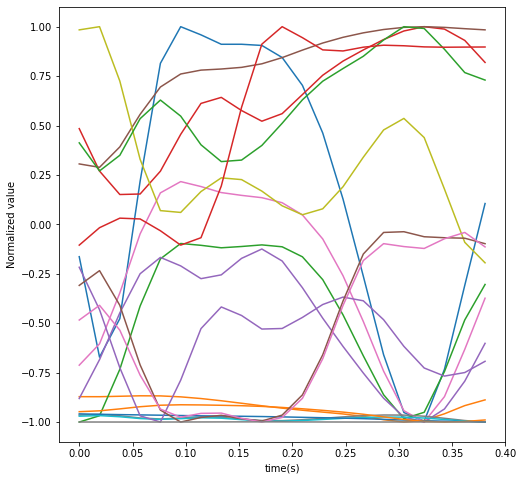

In [115]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
time_x = [i * 4 / 210 for i in range(0,21)]
for i, col in enumerate(ts_cols):
    ax.plot(time_x, sample_data[:,i].reshape(-1,), label = col)

# ax.legend(loc = 'upper left')
ax.set_xlabel("time(s)")
ax.set_ylabel("Normalized value")